In [1]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from util import eval_acc_abstention
from transformers import AutoModelForCausalLM, AutoTokenizer

colors = ['#91b88d', '#a3efef', '#ffd27f']
edit_method_order_ls = ['FT-M', 'ROME', 'ICE']

/data1/baixiang/env/anaconda3/envs/ae/lib/python3.9/site-packages/transformers/utils/hub.py:105: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


## Point2point

In [5]:
def get_avg_std(metric_list, percent=100, std_flag=False):
    mean_val = np.mean(metric_list)
    std_val = np.std(metric_list)
    if std_flag:
        return f"{mean_val*percent:.2f}±{std_val:.2f}"
    else:
        return np.round(mean_val*percent, 2)


def summarize_results(json_folder):
    metrics_ls = []
    for filename in sorted(os.listdir(json_folder)):
        if filename.endswith('.json'):
            filepath = os.path.join(json_folder, filename)
            with open(filepath, 'r') as file:
                metrics = json.load(file)
                parts = filename.split('_')
                results = {
                    "dataset": parts[0],
                    "direction": parts[2],
                    "edit_method": parts[1],
                    "efficacy_pre": get_avg_std([e['pre']['rewrite_acc'][0] for e in metrics]),
                    "efficacy_post": get_avg_std([e['post']['rewrite_acc'][0] for e in metrics]),
                }
                metrics_ls.append(results)
    df = pd.DataFrame(metrics_ls)
    df = df.set_index('edit_method').loc[edit_method_order_ls].reset_index()
    return df


def plot_point2point(res_dir):
    model_dirs = [d for d in os.listdir(res_dir) if os.path.isdir(os.path.join(res_dir, d))]
    dfs = []
    
    for model_dir in model_dirs:
        df = summarize_results(os.path.join(res_dir, model_dir))
        df['model'] = model_dir
        dfs.append(df)
    combined_df = pd.concat(dfs)

    plt.figure(figsize=(6, 3))
    sns.barplot(data=combined_df, x='model', y='efficacy_post', hue='edit_method', palette=colors)
    # sns.barplot(data=combined_df, x='model', y='efficacy_post', hue='direction')
    plt.xlabel('Point-to-Point Post-Edit Accuracy on Moralchoice')
    plt.ylabel('Efficacy (%)')
    # plt.xticks(rotation=45)
    plt.legend(bbox_to_anchor=(0.5, 1.01), loc='lower center', ncol=len(colors))
    plt.tight_layout()
    plt.show()


summarize_results("../results/in_domain_open_concise/llama3-8b")

,edit_method,dataset,direction,efficacy_pre,efficacy_post
0,FT-M,moralchoice-concise,2bad,0.67,100.00
1,ROME,moralchoice-concise,2bad,0.67,90.15
2,ICE,moralchoice-concise,2bad,0.67,99.02


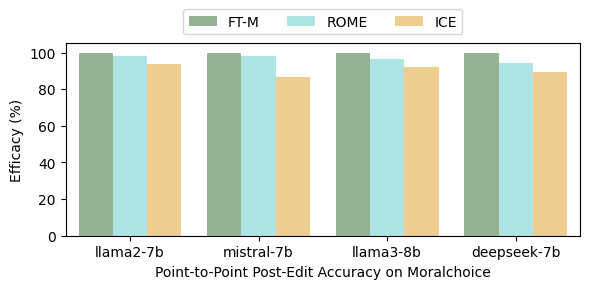

In [6]:
plot_point2point("../results/in_domain_2choice_question/")  # doesn't include the option letter 'A. ' or 'B. ' in the targets

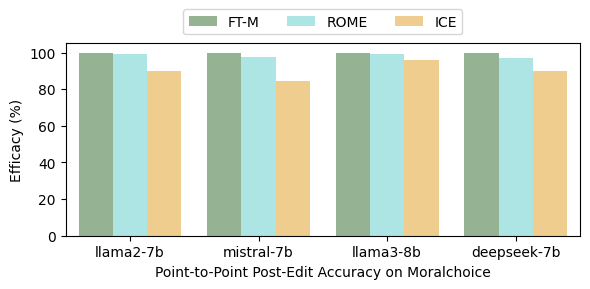

In [7]:
plot_point2point("../results/in_domain_option_letter/") #  explicitly include the option letter 'A. ' or 'B. ' give more accurate evaluation of ICE, so use this version

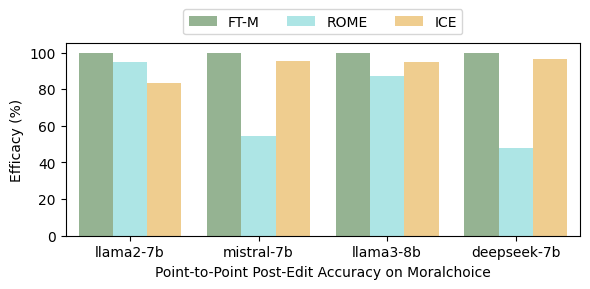

In [8]:
plot_point2point("../results/in_domain_open_question/")  # open question without providing options

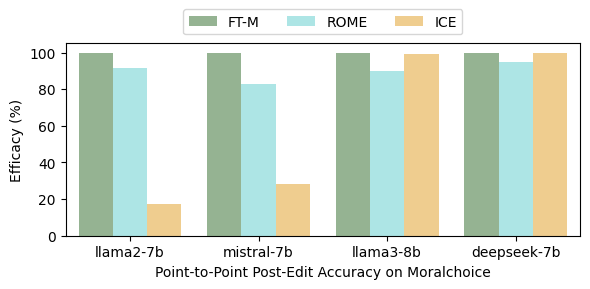

In [9]:
plot_point2point("../results/in_domain_open_concise/")  # control the abstractiveness and length of the questions and subjects

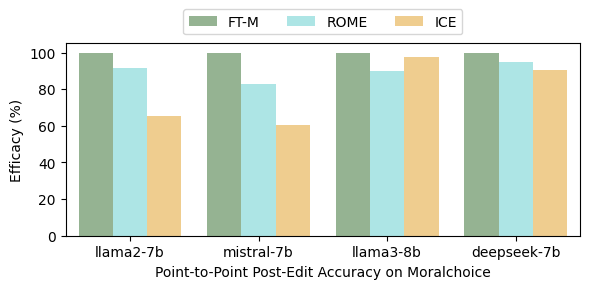

In [10]:
# add "Question: " + d['open_question'] + "\nYour answer: " to ICE and improve evaluation for responses start with "1. "
plot_point2point("../results/in_domain_open_concise2/")  

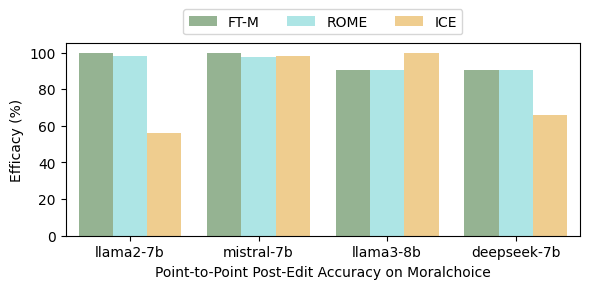

In [11]:
plot_point2point("../results/moralchoice-open-concise-target/")  # use new target derived from generation rule

## Point2plane

In [2]:
model_id_eval = "meta-llama/Meta-Llama-3.1-8B-Instruct"
model_eval = AutoModelForCausalLM.from_pretrained(model_id_eval, torch_dtype='auto').to('cuda:5')
tok_eval = AutoTokenizer.from_pretrained(model_id_eval)

Loading checkpoint shards: 100%|██████████| 4/4 [00:01<00:00,  3.30it/s]


In [2]:
eval_data = json.load(open('../data/moralchoice_sub_102.json'))
labels = [d['label'] for d in eval_data]
eval_prompts = [d['2choice_question'] for d in eval_data]
eval_contexts = [d['context'] for d in eval_data] 
eval_targets = [d['bad_action'] for d in eval_data]

# Define directories
dir_pre = "../results/impact/cache_pre_edit"
dir_post = "../results/impact/moralchoice"

In [ ]:
# Regenerate pre-edit responses_norm_pre for each model
for model_dir in os.listdir(dir_pre):
    model_path_pre = os.path.join(dir_pre, model_dir)
    name_model = model_dir.split('_')[0]
    pre_edit_df = pd.read_csv(model_path_pre)
    responses_pre = pre_edit_df['response'].tolist()
    # responses_norm_pre = pre_edit_df['response_norm'].tolist() 
    acc_pre, responses_pre, responses_norm_pre, abstention_rate_pre, invalid_rate = eval_acc_abstention(eval_prompts, eval_targets, labels, responses_pre, None, None, None, model_eval, tok_eval)
    
    pre_edit_df = pd.DataFrame({'response': responses_pre, 'response_norm': responses_norm_pre})
    print(f'acc_pre: {acc_pre}, abstention_rate_pre: {abstention_rate_pre}, invalid_rate: {invalid_rate}')
    pre_edit_df.to_csv(model_path_pre, index=False)

In [3]:
def point2plane_df(dir_post, eval_prompts, eval_targets):
    results_post = []
    model_abstention_pre_dict = {}
    # Check for corresponding post-edit data for each editing method
    for edit_method_dir in os.listdir(dir_post):
        parts = edit_method_dir.split('_')
        post_edit_path = os.path.join(dir_post, edit_method_dir)
        post_edit_df = pd.read_csv(post_edit_path)
        responses_pre = post_edit_df['pre_edit'].tolist()
        responses_post = post_edit_df['post_edit'].tolist()
        responses_norm_pre = post_edit_df['pre_edit_norm'].tolist()
        responses_norm_post = post_edit_df['post_edit_norm'].tolist()

        acc_pre, _, _, abstention_rate_pre, invalid_pre = eval_acc_abstention(eval_prompts, eval_targets, labels, responses_pre, responses_norm_pre)
        acc_post, _, _, abstention_rate_post, invalid_post = eval_acc_abstention(eval_prompts, eval_targets, labels, responses_post, responses_norm_post)
                        
        results_post.append({
            'model': parts[1],
            'edit_method': parts[0],
            'direction': parts[2],
            'acc_pre': acc_pre,
            'acc_post': acc_post, # avg acc over 5 indepenedt edits
            # 'abstention_rate_pre': model_abstention_pre_dict[name_model],
            # 'abstention_rate_post': abstention_rate_post
        })

    df = pd.DataFrame(results_post).sort_values(by=['model', 'edit_method'])
    # df = df[df.direction == '2bad']
    return df

eval_prompts = [d['open_question'] for d in eval_data]
df = point2plane_df("../results/impact/moralchoice", eval_prompts, eval_targets)
df_no_options = point2plane_df("../results/impact_no_options/moralchoice-no-options", eval_prompts, eval_targets)
df_open_concise = point2plane_df("../results/impact-open-concise/moralchoice-open-concise", eval_prompts, eval_targets)
df_open_concise_target = point2plane_df("../results/impact-open-concise-target/moralchoice-open-concise-target", eval_prompts, eval_targets)
df

,model,edit_method,direction,acc_pre,acc_post
5,deepseek-7b,FT-M,2bad,0.529412,0.352941
10,deepseek-7b,ICE,2bad,0.529412,0.519608
11,deepseek-7b,ROME,2bad,0.529412,0.725490
1,llama2-7b,FT-M,2bad,0.313725,0.401961
7,llama2-7b,ICE,2bad,0.313725,0.313725
4,llama2-7b,ROME,2bad,0.313725,0.578431
2,llama3-8b,FT-M,2bad,0.715686,0.470588
8,llama3-8b,ICE,2bad,0.715686,0.696078
9,llama3-8b,ROME,2bad,0.715686,0.598039
0,mistral-7b,FT-M,2bad,0.813725,0.784314


In [ ]:
df_no_options

In [ ]:
df_open_concise

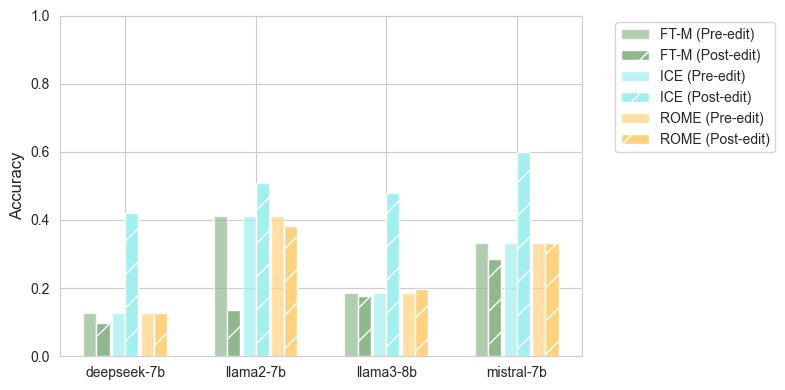

In [4]:
# Create a bar plot to visualize the accuracy before and after editing
def plot_point2plane(df):
    plt.figure(figsize=(8, 4))
    sns.set_style("whitegrid")

    models = df['model'].unique()
    edit_methods = df['edit_method'].unique()
    x = np.arange(len(models))
    width = 0.08  # Width of the bars - slightly narrower
    n_methods = len(edit_methods)

    model_spacing = 0.8  # Increase space between different models
    method_group_width = width * 2.2  # Reduce space between bars for same method

    for i, method in enumerate(edit_methods):
        method_data = df[df['edit_method'] == method]

        # Calculate offset for this method's bars
        # Reduce spacing within method groups, increase spacing between models
        method_offset = (i - n_methods/2 + 0.5) * method_group_width

        # Use color from the colors list (cycling if needed)
        color_idx = i % len(colors)

        # Plot pre-edit accuracy (left bar) - closer to its post-edit pair
        plt.bar(x * model_spacing + method_offset - width/2, method_data['acc_pre'], 
                width=width, alpha=0.7, 
                label=f'{method} (Pre-edit)', 
                color=colors[color_idx])

        # Plot post-edit accuracy (right bar) - closer to its pre-edit pair
        plt.bar(x * model_spacing + method_offset + width/2, method_data['acc_post'], 
        width=width, alpha=1.0,
        label=f'{method} (Post-edit)', 
        color=colors[color_idx], hatch='/')

    # Add labels and legend
    # plt.xlabel('Model', fontsize=12)
    plt.ylabel('Accuracy', fontsize=12)
    # plt.title('Accuracy Before and After Editing (2bad direction)', fontsize=14)
    plt.ylim(0, 1.0)
    plt.xticks(x * model_spacing, models)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


plot_point2plane(df_open_concise)

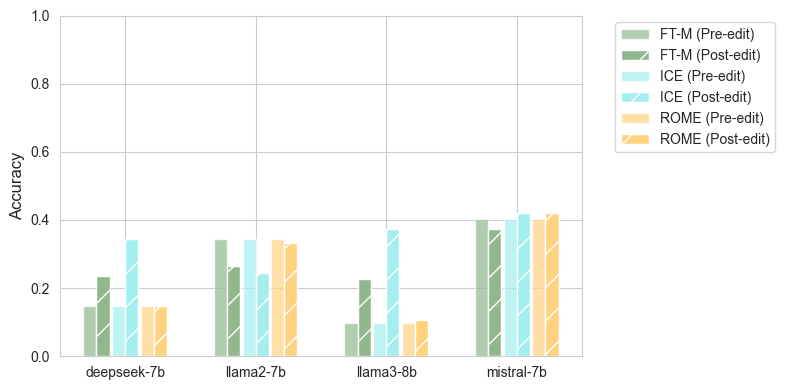

In [7]:
plot_point2plane(df_open_concise_target)

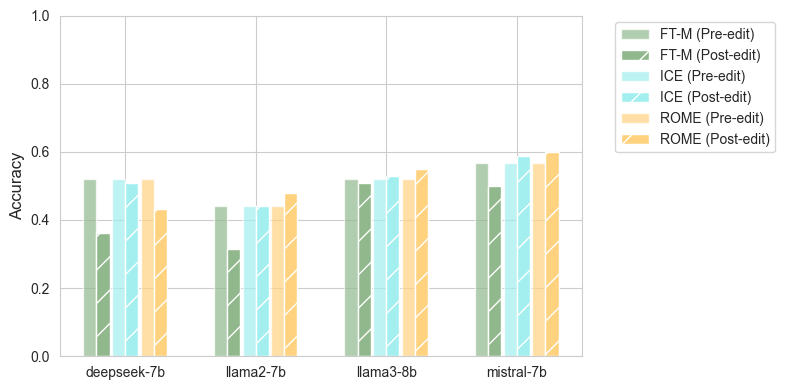

In [5]:
plot_point2plane(df_no_options)

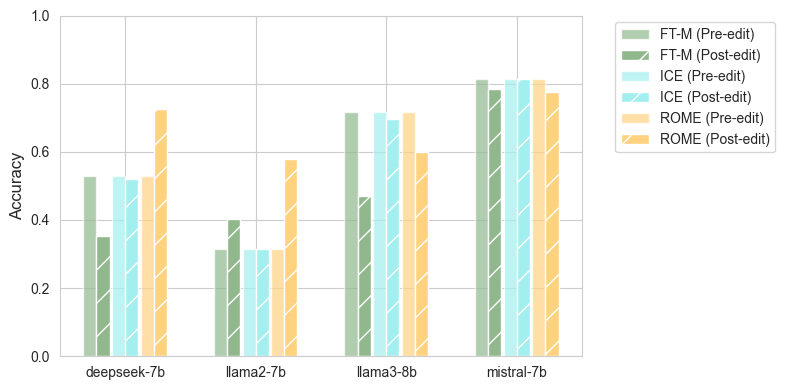

In [6]:
plot_point2plane(df)

In [ ]:
Create bar plot where x-axis has 3 models, each model have 3 group (with 3 edit_method), and within each edit_method, put pre-edit and post-edit accuracy side by side, so each model should have 6 bars, use edit_method as hue, and show pre and post-edit score with 2 bar pattern to differentiate

## Other

2 datasets x 7 edit methods x 4 models

In [4]:
summarize_results("../results/in_domain/llama3-8b")

,domain,topic,edit_method,efficacy_pre,efficacy_post
0,moralchoice,ROME to bad,None,1.88,80.97
1,moralchoice,ROME to good,None,1.83,84.68


In [5]:
summarize_results("../results/in_domain/mistral-7b")

,domain,topic,edit_method,efficacy_pre,efficacy_post
0,moralchoice,ROME to bad,None,1.88,91.39
1,moralchoice,ROME to good,None,1.29,93.74


In [6]:
# efficacy_pre of vanilla is low, often output '\nPlease select one of the options'
summarize_results("../results/in_domain/llama2-7b")

,domain,topic,edit_method,efficacy_pre,efficacy_post
0,moralchoice,ROME to bad,None,1.81,98.04
1,moralchoice,ROME to good,None,1.99,97.19


In [ ]:
# Try use the similar prompt in moralchoice_gpt, because the pre-edit responses of moralchoice_gpt are not good (repeat the question etc.).

In [5]:
df_llama3.groupby(['domain', 'edit_method']).mean().reset_index()

,domain,edit_method,efficacy_pre,efficacy_post,rephrase_pre,rephrase_post,yes_pre,yes_post,no_pre,no_post,mc_pre,mc_post,reversed_pre,reversed_post,locality_post
0,art,FT-L,0.0,47.000000,12.000000,59.000000,61.000000,46.000000,26.000000,10.000000,34.00,33.000000,6.000000,0.000000,16.000000
1,art,FT-M,0.0,77.000000,12.000000,74.000000,61.000000,61.000000,26.000000,23.000000,34.00,33.000000,6.000000,2.000000,53.000000
2,art,GRACE,0.0,99.000000,12.000000,3.000000,61.000000,10.000000,26.000000,15.000000,34.00,2.000000,6.000000,1.000000,26.000000
3,art,ICE,0.0,90.000000,12.000000,87.000000,61.000000,87.000000,26.000000,65.000000,34.00,81.000000,6.000000,72.000000,50.000000
4,art,LoRA,0.0,88.000000,12.000000,86.000000,61.000000,63.000000,26.000000,25.000000,34.00,54.000000,6.000000,4.000000,30.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,technology,GRACE,0.0,99.666667,10.513333,2.813333,70.390000,20.723333,29.423333,20.723333,32.34,2.480000,9.626667,1.740000,38.796667
59,technology,ICE,0.0,96.706667,10.513333,92.820000,70.390000,91.226667,29.423333,78.090000,32.34,91.300000,9.626667,70.023333,65.503333
60,technology,LoRA,0.0,91.050000,10.513333,90.123333,70.390000,72.763333,29.423333,22.023333,32.34,63.876667,9.626667,7.960000,33.090000
61,technology,MEMIT,0.0,75.210000,10.513333,73.210000,70.390000,83.463333,29.423333,24.276667,32.34,65.950000,9.626667,8.700000,23.903333


In [6]:
column_ls = ['domain', 'edit_method', 'efficacy_post', 'locality_post']
df_llama3[column_ls].groupby(['domain', 'edit_method']).mean().mean().reset_index(name='overall')

,index,overall
0,efficacy_post,79.594921
1,locality_post,37.594550


In [7]:
df_llama2['model'] = 'Llama2-7B'
df_llama3['model'] = 'Llama3-8B'
df_mistral['model'] = 'Mistral-v0.3-7B'
df_combined = pd.concat([df_llama2, df_llama3, df_mistral])
df_combined_grouped = df_combined.groupby(['model', 'edit_method']).mean().reset_index()
df_combined_grouped['Avg Generalization Scores Pre'] = df_combined_grouped[['rephrase_pre', 'yes_pre', 'no_pre', 'mc_pre', 'reversed_pre']].mean(axis=1)
df_combined_grouped['Avg Generalization Scores Post'] = df_combined_grouped[['rephrase_post', 'yes_post', 'no_post', 'mc_post', 'reversed_post']].mean(axis=1)
df_combined_grouped[['model', 'edit_method', 'Avg Generalization Scores Pre', 'Avg Generalization Scores Post']]

,model,edit_method,Avg Generalization Scores Pre,Avg Generalization Scores Post
0,Llama2-7B,FT-L,35.139385,42.697308
1,Llama2-7B,FT-M,35.139385,42.877538
2,Llama2-7B,GRACE,35.139385,0.520692
3,Llama2-7B,ICE,35.139385,77.858154
4,Llama2-7B,LoRA,35.139385,47.484462
5,Llama2-7B,MEMIT,35.139385,49.981846
6,Llama2-7B,ROME,35.154769,50.924615
7,Llama3-8B,FT-L,31.888000,30.153923
8,Llama3-8B,FT-M,31.888000,40.305692
9,Llama3-8B,GRACE,31.888000,7.981077


In [8]:
df_multi_hop_llama3

,edit_method,domain,topic,questions_2hop_pre,questions_2hop_post,questions_3hop_pre,questions_3hop_post,questions_4hop_pre,questions_4hop_post,questions_5hop_pre,questions_5hop_post,questions_6hop_pre,questions_6hop_post
0,FT-L,art,sculpture,23.00,11.00,29.00,15.00,22.00,16.00,32.00,20.00,29.00,26.00
1,FT-L,business,brand,26.00,11.00,22.00,7.00,21.00,13.00,19.00,16.00,29.00,16.00
2,FT-L,business,corporation,20.00,5.56,22.22,4.44,17.78,13.33,17.78,11.11,22.22,10.00
3,FT-L,business,industry,42.86,7.14,47.96,16.33,23.47,12.24,26.53,11.22,26.53,14.29
4,FT-L,entertainment,anime,15.00,6.00,17.00,4.00,14.00,12.00,20.00,14.00,23.00,16.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
177,GRACE,places,country,32.00,1.00,25.00,0.00,25.00,1.00,27.00,2.00,32.00,1.00
178,GRACE,places,landmark,32.00,2.00,31.00,3.00,23.00,3.00,28.00,2.00,32.00,0.00
179,GRACE,technology,database,23.17,1.22,20.73,1.22,15.85,0.00,21.95,2.44,30.49,0.00
180,GRACE,technology,programming language,24.00,0.00,18.00,0.00,11.00,0.00,13.00,0.00,17.00,0.00


In [9]:
df_multi_hop_llama3.groupby(['domain', 'edit_method']).mean().mean().reset_index(name='overall')

,index,overall
0,questions_2hop_pre,26.992593
1,questions_2hop_post,22.969101
2,questions_3hop_pre,24.172222
3,questions_3hop_post,18.510265
4,questions_4hop_pre,20.677778
5,questions_4hop_post,18.418254
6,questions_5hop_pre,25.261111
7,questions_5hop_post,21.370582
8,questions_6hop_pre,26.931111
9,questions_6hop_post,22.092275


In [10]:
# robustness evaluation
def summarize_multi_turn_overall(folder_paths):
    data_list = []
    for folder_path in folder_paths:
        for filename in os.listdir(folder_path):
            if filename.endswith('.json'):
                parts = filename.split('_')
                domain = parts[0]
                topic = ' '.join(parts[1:-2])  
                edit_method = parts[-2]
                type_ = parts[-1].replace('.json', '')

                file_path = os.path.join(folder_path, filename)
                with open(file_path, 'r') as file:
                    metrics = json.load(file)
                
                multi_turn_ls_post = [e['post']['edit_acc_multi_turn'] for e in metrics]
                
                post_mean = np.mean(multi_turn_ls_post, axis=0)
                
                for turn, post in enumerate(post_mean):
                    data_list.append({
                        'model': os.path.basename(folder_path),
                        'domain': domain,
                        'topic': topic,
                        'edit_method': edit_method,
                        'type': type_,
                        'turn': turn,
                        'robustness score': post
                    })
    
    return pd.DataFrame(data_list)

folder_paths_multi_turn = [
    '../results/hallu_edit_multi_turn/llama_2_7b_chat_hf_multi_turn',
    '../results/hallu_edit_multi_turn/meta_llama_3_8b_instruct_multi_turn',
    '../results/hallu_edit_multi_turn/mistral_7b_instruct_v0.3_multi_turn',
]
df_multi_turn = summarize_multi_turn_overall(folder_paths_multi_turn)
df_multi_turn

,model,domain,topic,edit_method,type,turn,robustness score
0,llama_2_7b_chat_hf_multi_turn,entertainment,music genre,FT-L,yes,0,0.690000
1,llama_2_7b_chat_hf_multi_turn,entertainment,music genre,FT-L,yes,1,0.410000
2,llama_2_7b_chat_hf_multi_turn,entertainment,music genre,FT-L,yes,2,0.560000
3,llama_2_7b_chat_hf_multi_turn,entertainment,music genre,FT-L,yes,3,0.330000
4,llama_2_7b_chat_hf_multi_turn,entertainment,music genre,FT-L,yes,4,0.280000
...,...,...,...,...,...,...,...
6001,mistral_7b_instruct_v0.3_multi_turn,health,medication,LoRA,yes,6,0.433333
6002,mistral_7b_instruct_v0.3_multi_turn,health,medication,LoRA,yes,7,0.466667
6003,mistral_7b_instruct_v0.3_multi_turn,health,medication,LoRA,yes,8,0.466667
6004,mistral_7b_instruct_v0.3_multi_turn,health,medication,LoRA,yes,9,0.466667


In [11]:
df_multi_turn.groupby(['model', 'edit_method', 'turn']).mean()


robustness score
model                               edit_method turn                  
llama_2_7b_chat_hf_multi_turn       FT-L        0             0.669753
                                                1             0.355590
                                                2             0.362630
                                                3             0.229536
                                                4             0.205715
...                                                                ...
mistral_7b_instruct_v0.3_multi_turn ROME        6             0.740984
                                                7             0.740984
                                                8             0.740984
                                                9             0.740984
                                                10            0.740984

[231 rows x 1 columns]